<a href="https://colab.research.google.com/github/leoexcelsus/siglla_phase2/blob/main/siglla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **SIGLLA - Fase II**



# **Bibliotecas**

In [ ]:
import pandas as pd
import sys
import csv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode

%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Salvando o modelo para posterior reuso
# from sklearn.externals import joblib
# from joblib import dump, load
# import re

# **Pré-processamento**

**Normas federais**

In [ ]:
csv.field_size_limit(sys.maxsize)
df = pd.read_csv('https://github.com/leoexcelsus/siglla_phase2/raw/main/ml_dataset_siglla%C2%A3.txt', sep="£",engine='python')
df['uf'] = 'BR'
df['esfera'] = 'federal'
df = df.replace({'value': {'sim': 1, 'n': 0}})

**Normas estaduais**

In [ ]:
csv.field_size_limit(sys.maxsize)
df_uf = pd.read_csv('https://github.com/leoexcelsus/siglla_phase2/raw/main/siglla_uf_test.csv', sep="£",engine='python', dtype={'value': int})
df_uf['esfera'] = 'estadual'
df_uf

,text,value,uf,esfera
0,"LEI Nº 13.798, DE 9 DE NOVEMBRO DE 2009 Instit...",1,SP,estadual
1,"LEI Nº 13.579, DE 13 DE JULHO DE 2009 Define a...",1,SP,estadual
2,"LEI Nº 13.577, DE 8 DE JULHO DE 2009 Dispõe so...",1,SP,estadual
3,"LEI Nº 13.550, DE 2 DE JUNHO DE 2009 Dispõe so...",1,SP,estadual
4,"LEI Nº 13.007, DE 15 DE MAIO DE 2008 (Projeto ...",1,SP,estadual
...,...,...,...,...
265,"LEI Nº 1.532, DE 22 DE DEZEMBRO DE 2004. Publi...",0,TO,estadual
266,"LEI Nº 2.732, DE 4 DE JUNHO DE 2013. Publicada...",0,TO,estadual
267,"LEI Nº 3.549, DE 31 DE OUTUBRO DE 2019. Public...",0,TO,estadual
268,"LEI Nº 2.534, DE 30 DE NOVEMBRO DE 2011. Publi...",0,TO,estadual


**Base completa**

In [ ]:
df_final = pd.concat([df, df_uf], ignore_index=True)
df_final
print (df_final.dtypes)
df['value'] = pd.to_numeric(df['value'], errors='coerce')

text      object
value      int64
uf        object
esfera    object
dtype: object


In [ ]:
# Dados nulos/faltantes
df_final.isnull().sum()

text      0
value     0
uf        0
esfera    0
dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
stop_words = nltk.corpus.stopwords.words('portuguese')

In [ ]:
# Padronizando texto com letras minúsculas, acentuação e lematização
!pip install unidecode
df_final['text'] = df_final.text.apply(str.lower)
df_final['text'] = df_final.text.apply(unidecode)

# **Análise exploratória dos dados**

**Base completa**

In [ ]:
df_final.value.value_counts()

0    266
1    263
Name: value, dtype: int64

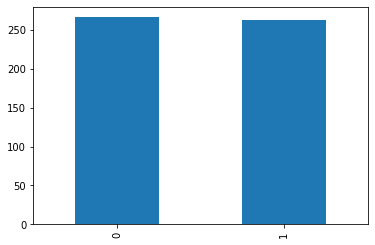

In [ ]:
df_final.value.value_counts().plot(kind='bar')

In [ ]:
grouped_uf = df_final.groupby('uf')
df_final['uf'].value_counts()

BR    259
GO     10
AM     10
RS     10
MG     10
PA     10
ES     10
MA     10
TO     10
PI     10
AL     10
PR     10
MS     10
RO     10
AC     10
RJ     10
SP     10
SE     10
RR     10
SC     10
BA     10
AP     10
RN     10
PE     10
PB     10
DF     10
CE     10
MT     10
Name: uf, dtype: int64

# **Classificação das normas federais**

In [ ]:
# Separa os dados de treino e teste (proporção 80/20)
X_train, X_test, y_train, y_test = train_test_split(df.text, df.value, test_size=0.2, 
                                                    stratify=df.value,random_state=42, shuffle=True)

In [ ]:
X_train[:10]

175    DIÁRIO OFICIAL DA UNIÃO Publicado em: 25/01/20...
150    PORTARIA Nº 224, DE 19 DE JUNHO DE 2015 O MINI...
172    Ir para o conteúdo Ir para o rodapé IR PARA O ...
147    RESOLUÇÃO No - 4.652, DE 1o - DE ABRIL DE 2015...
52     LEI No 9.985, DE 18 DE JULHO DE 2000. Regulame...
93     RESOLUÇÃO CONAMA nº 281, de 12 de julho de 200...
86     RESOLUÇÃO CONAMA Nº 23, DE 7.12.1994 - DOU 30....
252    O SUPERINTENDENTE DO PATRIMÔNIO DA UNIÃONO RIO...
256    PORTARIA N° 121, DE 1º DE MARÇO DE 2016 O SECR...
140    AÇÃO DIRETA DE INCONSTITUCIONALIDADE 3.580 (6)...
Name: text, dtype: object

In [ ]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (207,) 
 0    0.507246
1    0.492754
Name: value, dtype: float64 

TESTE  :  (52,) 
 1    0.5
0    0.5
Name: value, dtype: float64


In [ ]:
# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

Vocabulário: 
{'diário': 14015, 'oficial': 25762, 'da': 11416, 'união': 35244, 'publicado': 29264, 'em': 15108, '25': 1566, '01': 191, '2011': 1430, 'edição': 14747, '17': 1179, 'seção': 32601, 'página': 29333, 'órgão': 36598, 'presidência': 28444, 'república': 30870, 'casa': 7832, 'civil': 8474, 'portarias': 27963, 'de': 11744, '24': 1538, 'janeiro': 21428, 'ministro': 23883, 'estado': 16323, 'chefe': 8252, 'no': 24958, 'uso': 35309, 'suas': 33265, 'atribuições': 6092, 'etendo': 16620, 'vista': 35949, 'disposto': 13876, 'art': 5652, '1o': 1386, 'do': 14036, 'decreto': 12038, '734': 2543, '11': 642, 'dejunho': 12304, '2003': 1416, 'resolve': 30988, 'nº': 25262, '331': 1762, 'nomear': 25030, 'cláudio': 8600, 'frederico': 18279, 'matos': 23328, 'arruda': 5646, 'para': 26578, 'exercer': 16931, 'ocargo': 25602, 'assessoria': 5821, 'diplomática': 13683, 'vice': 35786, 'darepública': 11633, 'código': 11389, 'das': 11640, '101': 508, 'antonio': 4875, 'palocci': 26545, 'filho': 17724, 'portari

In [ ]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), # default hinge. to get proba=log or modified_huber
])

In [ ]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)

CPU times: user 2.61 s, sys: 94.7 ms, total: 2.7 s
Wall time: 2.66 s


In [ ]:
# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)

In [ ]:
# Mostra a acurácia do modelo nos dados de teste 
classificador.score(X_test,y_test)

0.9615384615384616

In [ ]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)

f1_score(y_test, predicted, average='weighted')

0.9614814814814815

In [ ]:
# avalie o modelo usando 'claasification_report' do sklearn
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.93      1.00      0.96        26

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



Matriz de confusão

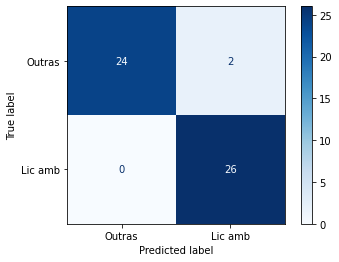

In [ ]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
plot_confusion_matrix(classificador, X_test, y_test,
                      cmap=plt.cm.Blues,
                      values_format='d', display_labels=('Outras', 'Lic amb'))

In [ ]:
# Descobrir quais leis foram preditas de forma errada
predicted = classificador.predict(X_test)
predicted == 1

array([False,  True, False,  True, False,  True,  True, False, False,
       False, False, False, False,  True, False,  True, False,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False, False,  True,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
        True, False,  True, False,  True,  True, False])

In [ ]:
X_test.loc[(predicted == 1) & (y_test == 0)]

165     DECRETO-LEI No 2.848, DE 7 DE DEZEMBRO DE 194...
214    PORTARIAS DE 2 DE SETEMBRO DE 2010 O PRESIDENT...
Name: text, dtype: object

In [ ]:
# fazer predição do tipo de norma para uma nova norma: [Resolução CONAMA 428/2010]
predicted = classificador.predict(['O CONSELHO NACIONAL DO MEIO AMBIENTE-CONAMA, no uso das atribuições e competências que lhe são conferidas pelo art. 8º da Lei nº 6.938, de 31 de agosto de 1981, regulamentado pelo Decreto nº 99.274, de 06 de julho de 1990 e tendo em vista o disposto em seu Regimento Interno, Anexo à Portaria MMA nº 168, de 13 de junho de 2005, e: Considerando a necessidade de regulamentar os procedimentos de licenciamento ambiental de empreendimentos de significativo impacto ambiental que afetem as Unidades de Conservação específicas ou suas zonas de amortecimento, resolve: Art. 1º O licenciamento de empreendimentos de significativo impacto ambiental que possam afetar Unidade de Conservação (UC) específica ou sua Zona de Amortecimento (ZA), assim considerados pelo órgão ambiental licenciador, com fundamento em Estudo de Impacto Ambiental e respectivo Relatório de Impacto Ambiental (EIA/RIMA), só poderá ser concedido após autorização do órgão responsável pela administração da UC ou, no caso das Reservas'])

In [ ]:
print('nova predição:\nclasse = ', predicted)
print('classe = ', df.value[predicted])

nova predição:
classe =  [1]
classe =  1    1
Name: value, dtype: int64


# **Classificação das normas estaduais**

In [ ]:
# Separa os dados de treino e teste (proporção 80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_uf.text, df_uf.value, test_size=0.2, 
                                                    stratify=df_uf.value,random_state=42, shuffle=True)

In [ ]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (216,) 
 1    0.5
0    0.5
Name: value, dtype: float64 

TESTE  :  (54,) 
 1    0.5
0    0.5
Name: value, dtype: float64


In [ ]:
# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

Vocabulário: 
{'lei': 11864, 'nº': 13292, '15': 246, '899': 1255, 'de': 6152, '05': 68, 'outubro': 13811, '2012': 431, 'procedência': 15177, 'dep': 6456, 'serafim': 17461, 'venzon': 19265, 'natureza': 13047, 'pl': 14484, '0105': 31, 'do': 7293, '19': 337, '434': 776, '09': 97, '10': 106, '12': 176, 'veto': 19322, 'parcial': 13963, 'msv': 12890, '00680': 22, 'fonte': 9374, 'alesc': 2071, 'coord': 5697, 'documentação': 7316, 'cria': 5892, 'ação': 3376, 'estadual': 8329, 'valorização': 19158, 'artesanato': 2846, 'no': 13150, 'estado': 8324, 'santa': 17137, 'catarina': 4060, 'adota': 1751, 'outras': 13806, 'providências': 15503, 'governador': 9896, 'faço': 9013, 'saber': 17061, 'todos': 18595, 'os': 13774, 'habitantes': 10031, 'deste': 6800, 'que': 15712, 'assembleia': 2908, 'legislativa': 11847, 'decreta': 6233, 'eu': 8491, 'sanciono': 17117, 'seguinte': 17311, 'art': 2838, '1º': 412, 'fica': 9122, 'criada': 5894, 'com': 4629, 'finalidade': 9178, 'contribuir': 5588, 'para': 13914, 'desenv

In [ ]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador

pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), # default hinge. to get proba=log or modified_huber
])

In [ ]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)

CPU times: user 1.72 s, sys: 109 ms, total: 1.82 s
Wall time: 1.73 s


In [ ]:
# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)

In [ ]:
# Mostra a acurácia do modelo nos dados de teste 
classificador.score(X_test,y_test)

0.8888888888888888

In [ ]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
f1_score(y_test, predicted, average='weighted')

0.8887362637362637

In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        27
           1       0.86      0.93      0.89        27

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54



**Matriz de confusão**

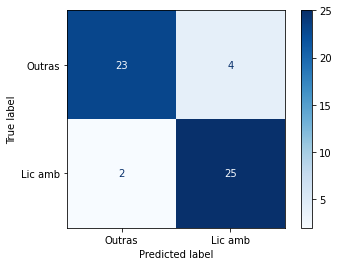

In [ ]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
plot_confusion_matrix(classificador, X_test, y_test,
                      cmap=plt.cm.Blues,
                      values_format='d', display_labels=('Outras', 'Lic amb'))

# **Classificação das normas (federais + estaduais)**



In [ ]:
# Separa os dados de treino e teste (proporção 80/20)
X_train, X_test, y_train, y_test = train_test_split(df_final.text, df_final.value, test_size=0.2, 
                                                    stratify=df_final.value,random_state=42, shuffle=True)

In [ ]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (423,) 
 0    0.503546
1    0.496454
Name: value, dtype: float64 

TESTE  :  (106,) 
 1    0.5
0    0.5
Name: value, dtype: float64


In [ ]:
# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, analyzer='word',
            ngram_range=(1, 1), lowercase=True, use_idf=True)
# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
tfidf_vector2 = tfidf_vectorizer.transform(X_test)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)
print('\nPeso de cada palavra no vocabulário:')
print(tfidf_vectorizer.idf_)

Vocabulário: 
{'resolucao': 36742, 'conjunta': 11874, 'sema': 38315, 'iap': 23364, '007': 190, '23': 1773, 'dezembro': 16137, '2015': 1643, 'publicado': 34674, 'diario': 16197, 'oficial': 30533, '9624': 3634, '27': 1905, 'janeiro': 25649, '2016': 1646, 'sumula': 39999, 'dispoe': 16593, 'sobre': 39185, 'procedimentos': 34035, 'operacionais': 30740, 'sistema': 39089, 'cadastro': 9040, 'ambiental': 5540, 'rural': 37587, 'sicar': 38803, 'parana': 31615, 'ambito': 5567, 'programa': 34218, 'regularizacao': 36106, 'estado': 19424, 'secretario': 38090, 'meio': 28008, 'ambiente': 5557, 'recursos': 35733, 'hidricos': 23097, 'designado': 15636, 'decreto': 14536, 'estadual': 19432, '16': 1311, '1o': 1598, 'uso': 41990, 'atribuicoes': 7507, 'sao': 37841, 'conferidas': 11713, 'lei': 26438, '485': 2514, '03': 332, 'junho': 25910, '1987': 1549, '10': 568, '006': 183, 'julho': 25887, '1992': 1556, 'alteracoes': 5393, 'posteriores': 33291, 'diretor': 16460, 'presidente': 33712, 'instituto': 24809, 'ndeg

**Palavras com mais peso**

In [ ]:
cvec = CountVectorizer(stop_words=stop_words, analyzer='word', ngram_range=(1, 1))
sf = cvec.fit_transform(df_final['text'].tolist())
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(sf)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'palavras': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(25)

,palavras,weight
7449,art,0.087613
5910,ambiental,0.056250
28362,lei,0.049135
42355,ss,0.045315
20781,estado,0.045241
41261,ser,0.031649
38314,recursos,0.031155
20790,estadual,0.029351
30050,meio,0.028424
25232,ii,0.026947


**SGD Classifier**

In [ ]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), # default hinge. to get proba=log or modified_huber
])

In [ ]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)

CPU times: user 3.86 s, sys: 197 ms, total: 4.06 s
Wall time: 3.95 s


In [ ]:
# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)

In [ ]:
# Mostra a acurácia do modelo nos dados de teste 
classificador.score(X_test,y_test)

0.9056603773584906

In [ ]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
f1_score(y_test, predicted, average='weighted')

0.9053571428571429

In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        53
           1       0.96      0.85      0.90        53

    accuracy                           0.91       106
   macro avg       0.91      0.91      0.91       106
weighted avg       0.91      0.91      0.91       106



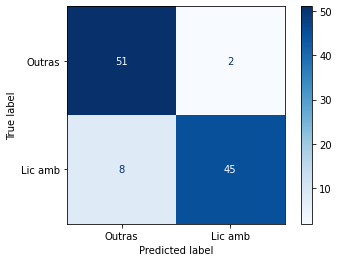

In [ ]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
plot_confusion_matrix(classificador, X_test, y_test,
                      cmap=plt.cm.Blues,
                      values_format='d', display_labels=('Outras', 'Lic amb'))

In [ ]:
X_test.loc[(predicted == 0) & (y_test == 1)]

270    lei no 2.302, de 11 de agosto de 2010 institui...
512    decreto no 27.410 de 11 de outubro de 2010 pub...
303    lei n.deg 3.262, de 30 de maio de 2008 institu...
432    decreto no 33.528, de 08 de junho de 2009. ins...
372    *lei complementar no 481, de 27 de dezembro de...
302    decreto n.o 24.237, de 18 de maio de 2.004 apr...
324    lei no 13.045, de 17.07.00 (do 27.07.00) dispo...
413    lei no 8.608 estado * da paraiba ,de 30 de jun...
Name: text, dtype: object

**Árvore de decisão**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

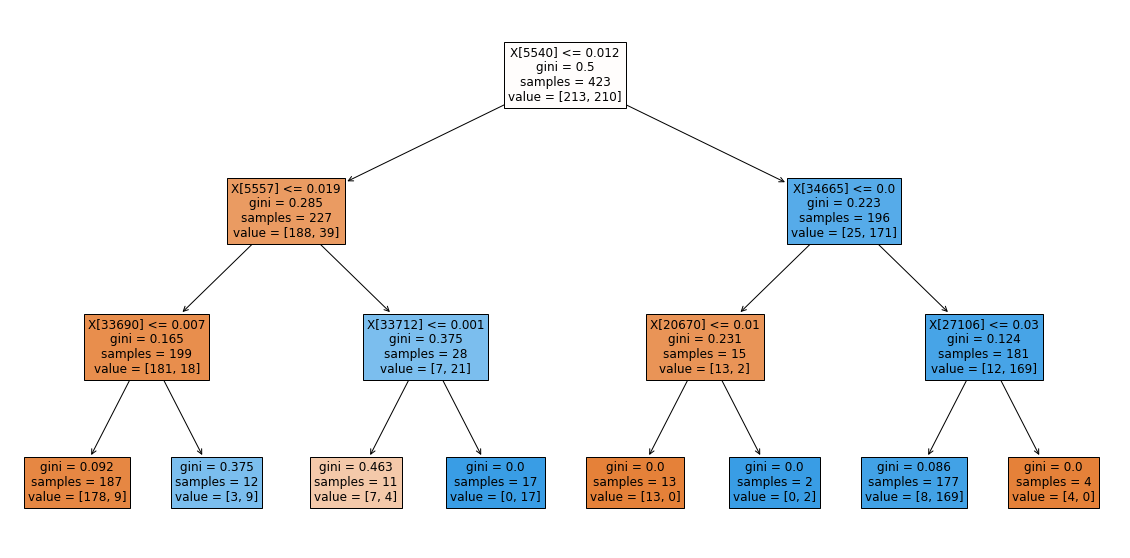

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(tfidf_vector, y_train)
clf.score(tfidf_vector, y_train)
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, fontsize=12)
plt.show()

In [ ]:
y_pred = clf.predict(tfidf_vector2)
accuracy = accuracy_score(y_pred, y_test)
print("Acurácia da Árvore de Decisão: ", accuracy)

Acurácia da Árvore de Decisão:  0.8490566037735849


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(bootstrap=True, criterion='gini', max_features='auto', random_state=123)
rfc.fit(tfidf_vector, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_rfc = rfc.predict(tfidf_vector2)
accuracy_rfc = accuracy_score(y_pred_rfc, y_test)
print("Acurácia do Random Forest Classifier: ", accuracy_rfc)

Acurácia do Random Forest Classifier:  0.8773584905660378


**Random Forest com Grid Search**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# setup do grid search

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = { 'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap }

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
# 3 fold CV, 10 combinations
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfc_random.fit(tfidf_vector, y_train)
rcf_uni_best_params = rfc_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


In [ ]:
rcf_uni = RandomForestClassifier(bootstrap=rcf_uni_best_params["bootstrap"], max_depth=rcf_uni_best_params["max_depth"], max_features=rcf_uni_best_params["max_features"], min_samples_leaf=rcf_uni_best_params["min_samples_leaf"], min_samples_split=rcf_uni_best_params["min_samples_split"], n_estimators=rcf_uni_best_params["n_estimators"], random_state=123)
rcf_uni.fit(tfidf_vector, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_rcf_uni = rcf_uni.predict(tfidf_vector2)
accuracy_rcf_uni = accuracy_score(y_pred_rcf_uni, y_test)
print("Acurácia do Random Forest Classifier (com Grid Search): ", accuracy_rcf_uni)

Acurácia do Random Forest Classifier (com Grid Search):  0.8867924528301887


# **Classificação por esfera**

In [ ]:
# Separa os dados de treino e teste (proporção 80/20)
X_train, X_test, y_train, y_test = train_test_split(df_final.text, df_final.esfera, test_size=0.2, 
                                                    stratify=df_final.esfera,random_state=42, shuffle=True)

In [ ]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (423,) 
 estadual    0.510638
federal     0.489362
Name: esfera, dtype: float64 

TESTE  :  (106,) 
 estadual    0.509434
federal     0.490566
Name: esfera, dtype: float64


In [ ]:
# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

Vocabulário: 
{'diario': 16048, 'oficial': 30372, 'da': 13708, 'uniao': 41601, 'publicado': 34499, 'em': 17869, '27': 1867, '04': 352, '2010': 1617, 'edicao': 17401, '78': 3112, 'secao': 37836, 'pagina': 31239, '33': 2050, 'orgao': 30772, 'ministerio': 28368, 'pesca': 32356, 'aquicultura': 6559, 'gabinete': 21860, 'do': 16688, 'ministro': 28384, 'portarias': 32987, 'de': 14062, '26': 1837, 'abril': 3888, 'estado': 19274, 'substituto': 39607, 'no': 29538, 'uso': 41754, 'suas': 39370, 'atribuicoes': 7413, 'tendo': 40394, 'vista': 42557, 'decretode': 14391, '20': 1594, 'assim': 7101, 'como': 10896, 'art': 6884, '87': 3347, 'constituicao': 12002, 'federal': 20655, 'odecreto': 30288, '532': 2588, '2008': 1611, 'bem': 8184, 'competencia': 11020, 'que': 34759, 'lhe': 26449, 'foisubdelegada': 21277, 'pela': 31928, 'portaria': 32979, '056': 412, '11': 716, 'junho': 25785, '2003': 1603, 'doministro': 16894, 'chefe': 10050, 'casa': 9508, 'civil': 10338, 'presidencia': 33527, 'republica': 36397, '

In [ ]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), # default hinge. to get proba=log or modified_huber
])

In [ ]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)

CPU times: user 3.9 s, sys: 153 ms, total: 4.06 s
Wall time: 3.95 s


In [ ]:
# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)

In [ ]:
# Mostra a acurácia do modelo nos dados de teste 
classificador.score(X_test,y_test)

0.9339622641509434

In [ ]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
f1_score(y_test, predicted, average='weighted')

0.9338739075335377

In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

    estadual       0.91      0.96      0.94        54
     federal       0.96      0.90      0.93        52

    accuracy                           0.93       106
   macro avg       0.94      0.93      0.93       106
weighted avg       0.94      0.93      0.93       106



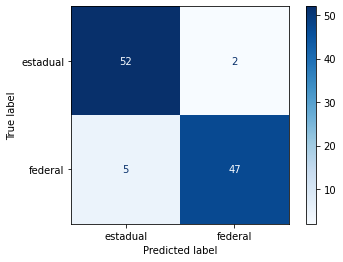

In [ ]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
plot_confusion_matrix(classificador, X_test, y_test,
                      cmap=plt.cm.Blues,
                      values_format='d')

# **Classificação por UF**

In [ ]:
# Separa os dados de treino e teste (proporção 80/20)
X_train, X_test, y_train, y_test = train_test_split(df_final.text, df_final.uf, test_size=0.2, 
                                                    stratify=df_final.uf,random_state=42, shuffle=True)

In [ ]:
# Confere a proporção das classes nos dados de treino e de teste
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (423,) 
 BR    0.489362
GO    0.018913
AC    0.018913
MG    0.018913
PA    0.018913
ES    0.018913
MA    0.018913
TO    0.018913
PI    0.018913
AL    0.018913
PR    0.018913
MS    0.018913
RO    0.018913
AM    0.018913
PB    0.018913
RJ    0.018913
SE    0.018913
RR    0.018913
SC    0.018913
BA    0.018913
AP    0.018913
SP    0.018913
CE    0.018913
RN    0.018913
PE    0.018913
DF    0.018913
RS    0.018913
MT    0.018913
Name: uf, dtype: float64 

TESTE  :  (106,) 
 BR    0.490566
GO    0.018868
AC    0.018868
MG    0.018868
PA    0.018868
ES    0.018868
MA    0.018868
TO    0.018868
PI    0.018868
AL    0.018868
PR    0.018868
MS    0.018868
RO    0.018868
AM    0.018868
SP    0.018868
RJ    0.018868
SE    0.018868
RR    0.018868
SC    0.018868
PE    0.018868
AP    0.018868
CE    0.018868
RN    0.018868
BA    0.018868
PB    0.018868
DF    0.018868
RS    0.018868
MT    0.018868
Name: uf, dtype: float64


In [ ]:
# instancia o transform CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
# tokeniza e cria o vocabulário
tfidf_vectorizer.fit(X_train)
# mostra o vocabulário criado
print('Vocabulário: ')
print(tfidf_vectorizer.vocabulary_)

# encode document
tfidf_vector = tfidf_vectorizer.transform(X_train)
# mostra as dimensões da matrix de frequência
print('\nDimensões da matrix: ')
print(tfidf_vector.shape)

Vocabulário: 
{'lei': 25710, 'no': 28897, '14': 1106, '285': 1841, 'de': 13627, 'agosto': 4520, '2013': 1588, 'altera': 5012, '676': 2725, 'julho': 25182, '1988': 1492, 'que': 34081, 'determina': 15377, 'obrigatoriedade': 29475, 'demarcacao': 14332, 'das': 13515, 'areas': 6313, 'pesca': 31711, 'lazer': 25633, 'ou': 30347, 'recreacao': 34832, 'nos': 29214, 'municipios': 28327, 'com': 10320, 'orla': 30211, 'maritima': 26959, 'lacustre': 25463, 'fluvial': 20675, 'governador': 21851, 'do': 16229, 'estado': 18744, 'rio': 36347, 'grande': 21935, 'sul': 39031, 'faco': 19864, 'saber': 36720, 'em': 17359, 'cumprimento': 13179, 'ao': 5706, 'disposto': 16037, 'artigo': 6568, '82': 3028, 'inciso': 23325, 'iv': 24868, 'da': 13279, 'constituicao': 11574, 'assembleia': 6699, 'legislativa': 25689, 'aprovou': 6122, 'eu': 19114, 'sanciono': 36877, 'promulgo': 33504, 'seguinte': 37277, 'art': 6528, '1o': 1545, 'ss': 38556, 'alterada': 5021, 'pela': 31292, '13': 1014, '660': 2696, '12': 863, 'janeiro': 24

In [ ]:
# Define o pipeline incluindo o extrator de 'features do texto e um classificador
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, max_features=50000,ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True,norm='l2')),
    ('clf', SGDClassifier(loss='log',alpha=1e-06, penalty='elasticnet', max_iter=60)), # default hinge. to get proba=log or modified_huber
])

In [ ]:
%%time
# Treine o modelo(fit)
classificador = pipeline.fit(X_train, y_train)

CPU times: user 6.39 s, sys: 1.87 s, total: 8.25 s
Wall time: 6.1 s


In [ ]:
# Faça a predição nos dados de teste
predicted = classificador.predict(X_test)

In [ ]:
# Mostra a acurácia do modelo nos dados de teste 
classificador.score(X_test,y_test)

0.7264150943396226

In [ ]:
# Mostra o f1 score do modelo nos dados de teste (usado quando as classes estão desbalanceadas)
f1_score(y_test, predicted, average='weighted')

0.6847142466502596

In [ ]:
# avalie o modelo usando 'classification_report' do sklearn
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          AC       1.00      0.50      0.67         2
          AL       1.00      1.00      1.00         2
          AM       1.00      1.00      1.00         2
          AP       1.00      0.50      0.67         2
          BA       0.50      0.50      0.50         2
          BR       0.78      0.94      0.85        52
          CE       0.67      1.00      0.80         2
          DF       0.00      0.00      0.00         2
          ES       1.00      1.00      1.00         2
          GO       0.00      0.00      0.00         2
          MA       0.67      1.00      0.80         2
          MG       0.50      0.50      0.50         2
          MS       0.50      0.50      0.50         2
          MT       0.67      1.00      0.80         2
          PA       0.00      0.00      0.00         2
          PB       0.50      0.50      0.50         2
          PE       0.00      0.00      0.00         2
          PI       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


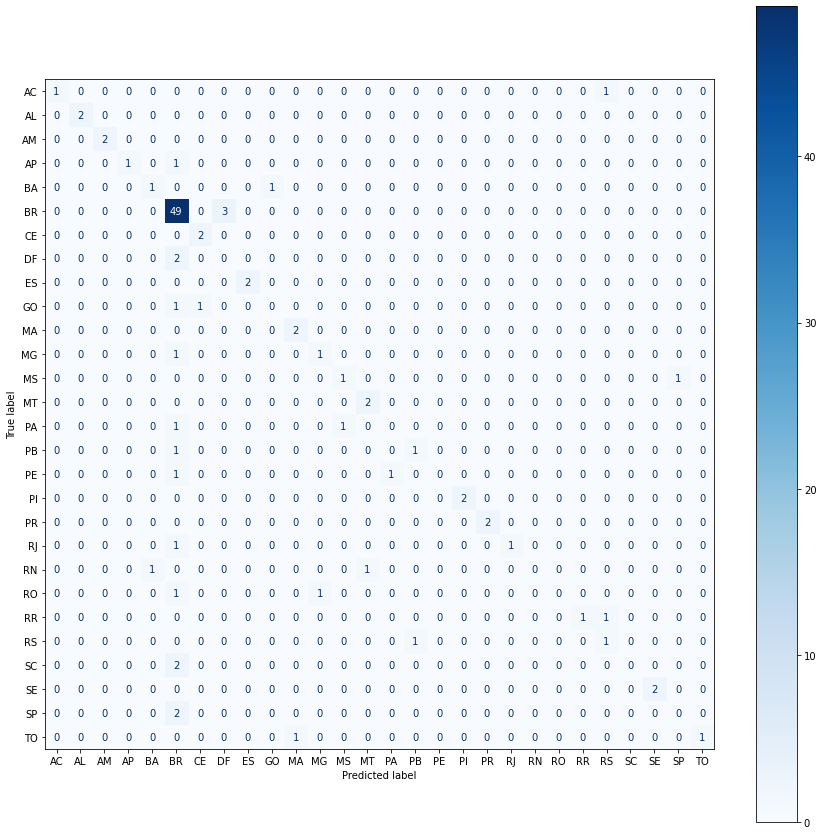

In [ ]:
# mostrar a matrix de confusão do modelo sobre todo o dataset
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(classificador, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.show()